# Convection - Diffusion Equation

Consider the 1d convection-diffusion equation with dirichlet boundary condition : 

$$ -\epsilon u'' + bu' = 1,\;\;\textrm{in} \;\;\Omega = [0,1]$$

$$ u(0) = u(1) = 0 $$

where, $\epsilon$ and b are diffusion and convection coefficients respectively.
We seek to find the solution $u \in V$, where $V$ is some finite element space satisfying the boundary condition.

The exact solution to the above problem is given by
$$ u = \frac{1}{b}\left(x - \frac{1-e^{\frac{bx}{\epsilon}}}{1-e^{\frac{b}{\epsilon}}}\right) $$

# Galerkin

We write the above problem in variational form by multiplying by test function $v \in V$ and integrating by parts over domain $\Omega$ 

$$ \int_\Omega (-\epsilon u'' + bu')v\,dx = \int_\Omega v\,dx $$

$$ \epsilon \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx = \int_\Omega v\,dx $$

Now let us write the problem in compact form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega v\,dx $$

The above problem is solved below by using `firedrake`.

Import the required libraries i.e firedrake, matplotlib and numpy to solve the problem.

In [1]:
import firedrake as fe
import matplotlib.pyplot as plt
import numpy as np

The mesh fo the above 1d problem is defined using `UnitIntervalMesh` from firedrake. Enter the value for N, the number of elements in the mesh.

In [2]:
N = 5
mesh = fe.UnitIntervalMesh(N)

Choose the value of diffusion coefficient $\epsilon$ and convection coefficient $b$.

In [3]:
e = 1  # diffusion constant 
b = 1 # convection constant

Mesh Peclet number is defined as 
$$ Pe = \frac{bh}{2\epsilon}$$
where $h$ is the mesh size. Here, $h = \frac{1}{N}$.

In [4]:
def peclet_number(b, N, epsilon):
    """ returns Peclet number
    
    Keyword Arguments:
    
    b - convection coefficient
    
    N - mesh size
    
    epsilon - diffusion coefficient
    """
    h = 1./N
    
    return b*h/(2.*e)

In [5]:
pe = peclet_number(b,N,e)
print('Pe =',pe)

Pe = 0.1


Now, we shall define the finite dimensional function space $V$ in which the problem is to be solved. It is defined using `FunctionSpace` from `firedrake` which takes the mesh, the finite element family and degree of the finite element family as inputs. We shall choose the space of piecewise linear polynomials that are continuous between elements.

In [6]:
V = fe.FunctionSpace(mesh, 'CG', 1)

Now, we shall define the test and trial function on the function space $V$ using `TrialFunction` and `TestFunction` by passing function space V as argument. 

In [7]:
u = fe.TrialFunction(V)
v = fe.TestFunction(V)

Let us get the spatial cordinates $x$ for the problem using `SpatialCoordinate` and passing our mesh as argument. 

In [8]:
x = fe.SpatialCoordinate(mesh)[0]

Let us now define the r.h.s of the equation . Since, the r.h.s is a constant (1 here), we shall use `Constant` function from `firedrake`.

In [9]:
f = fe.Constant(1)

Now we shall impose the Dirichlet Boundary condition for the problem. We need to first define the boundary ids. To determine the boundary ids we call help for `UnitIntervalMesh` as follows.

In [10]:
help(fe.UnitIntervalMesh)

Help on function UnitIntervalMesh in module firedrake.utility_meshes:

UnitIntervalMesh(ncells, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7fccb01d0048>)
    Generate a uniform mesh of the interval [0,1].
    
    :arg ncells: The number of the cells over the interval.
    :kwarg comm: Optional communicator to build the mesh on (defaults to
        COMM_WORLD).
    
    The left hand (:math:`x=0`) boundary point has boundary marker 1,
    while the right hand (:math:`x=1`) point has marker 2.



 For `UnitIntervalMesh` the boundary ids $1$ and $2$ correspond to $x=0$ and $x=1$ respectively. Once we define the boundary ids we impose the Dirichlet boundary conditions by using `DirichletBC` object from `firdrake` by passing function space $V$, the value at boundary ($0$ here) and boundary ids as arguments.

In [11]:
boundary_ids = {1,2} # boundaries x=0 and x=1
bc = fe.DirichletBC(V,0,boundary_ids) # Boundary conditions for x=0and x=1, u=0

Let us define $u_h \in V$ holding the solution. We shall do that by declaring $u_h$ as a `Function` in V.

In [12]:
uh = fe.Function(V)

Let us now define the linear and bilinear form as follows.

In [13]:
L = f*v*fe.dx
a =  ( e* fe.dot(fe.grad(v),fe.grad(u)) ) * fe.dx + b * u.dx(0) * v * fe.dx 

Now we shall solve the problem by imposing the boundary conditions. Use `solve` from `firedrake` by passing the necessary arguments. Here, we impose the boundary conditions.

In [14]:
fe.solve(a == L, uh, bcs=bc)

Now we shall plot the results using the `plot` function.

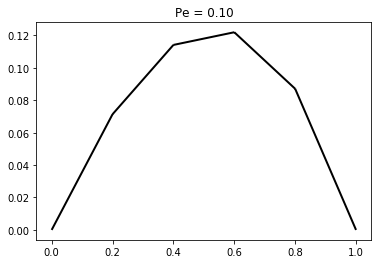

In [15]:
fe.plot(uh)
_  = plt.title('Pe = %.2f'%pe)

Since we have the exact solution to the problem, we shall look at the error produced.

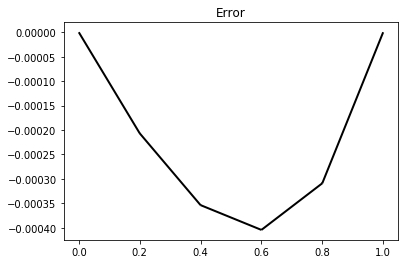

In [16]:
u_exact = (x - (1-fe.exp(b*x/e))/(1-fe.exp(b/e)))/b
difference = fe.assemble(fe.interpolate(u_exact, V) - uh)
fe.plot(difference)
_ = plt.title('Error')

We can determine the L-2 error which is defined as $||u_h - u||_2 = \sqrt{ \int (u-u_h)^2 dx}$

In [17]:
# L-2 Error
L_2_err = fe.sqrt(fe.assemble(fe.dot(uh - u_exact, uh - u_exact) * fe.dx))
print("L-2 Error = ",L_2_err)

L-2 Error =  0.0035664534409275603


Since the 1d plotting interface of `firedrake` is a bit difficult to visualize the numerical solution and the exact solution, we shall use the `matplotlib.pyplot` to plot. We define a function `myplot` which takes numerical solution $u_h$, diffusion coefficient $b$ and convection coefficient $\epsilon$ as arguments and plots the exact and numerical solution. 

In [20]:
def myplot(uh, b, epsilon, pe):
    """Plots 1d solution and exact solution
    
    Key arguments:
    
    uh - Numerical solution to the 1-d problem
    
    b - convection coefficient
    
    epsilon - diffusion coefficient
    
    pe - Peclet number
    
    """
    x = np.arange(0,1.0001,0.1)


    plt.plot(x,uh(x),'--ob', label = '$u_h$')

    x = np.arange(0,1.0001,0.0001)
    u_exact = (x - (1-np.exp(b*x/e))/(1-np.exp(b/e)))/b

    plt.plot(x,u_exact,'-g', label = '$u_{exact}$')
    plt.title('Pe = %.2f '%pe)
    plt.legend(loc = 'upper left')
    plt.grid(True)
    
    return

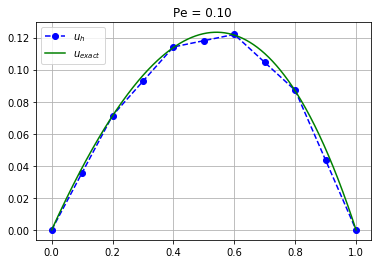

In [21]:
myplot(uh,b,e, pe)

Now, let us write the code as a function which solves the above problem by Galerkin by taking convection coefficient $\epsilon$, diffusion coefficient $b$ and mesh size $N$ as arguments.

In [22]:
def galerkin(epsilon, b, N):
    """Solves the 1-d problem by Galerin
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b -  convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon
    
    mesh = fe.UnitIntervalMesh(N)
    
    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)
    
    V = fe.FunctionSpace(mesh, 'CG', 1)
    
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    
    x = fe.SpatialCoordinate(mesh)[0]
    
    f = fe.Constant(1)
    
    boundary_ids = {1,2} # boundaries x=0 and x=1
    bc = fe.DirichletBC(V,0,boundary_ids) # Boundary conditions for x=0and x=1, u=0
    
    uh = fe.Function(V)
    
    L = f*v*fe.dx
    a =  ( e* fe.dot(fe.grad(v),fe.grad(u)) ) * fe.dx + b * u.dx(0) * v * fe.dx 
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return 
    
    
    
    

Pe = 0.05


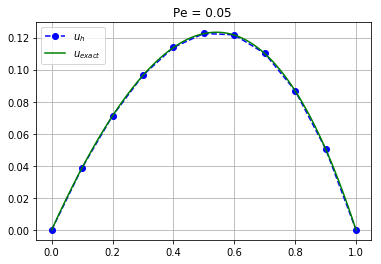

In [23]:
galerkin(1,1,10)

Pe = 0.5


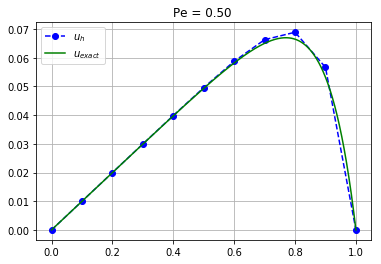

In [24]:
galerkin(1,10,10)

Pe = 1.0


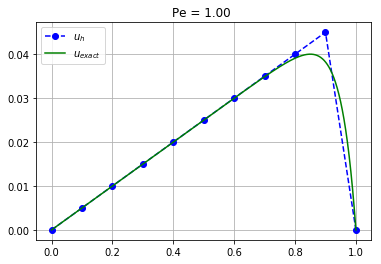

In [25]:
galerkin(1,20,10)

Pe = 2.5


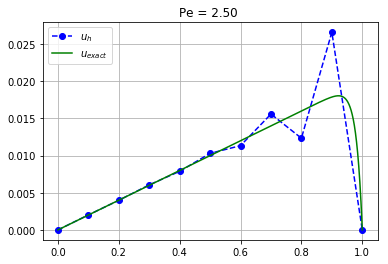

In [26]:
 galerkin(1,50,10)

Pe = 5.0


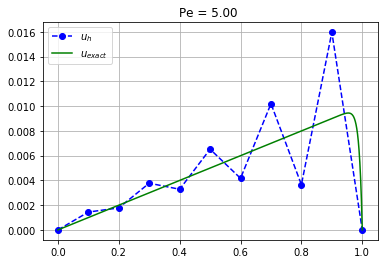

In [27]:
galerkin(1,100,10)

Pe = 25.0


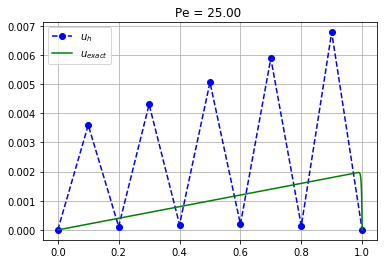

In [28]:
galerkin(1,500,10)

It can be seen that for vanishing diffusion i.e $ \epsilon \rightarrow 0$ PDE problem is not well posed as a boundary value problem. It can be seen that the Galerkin method has problems in the convection dominated case $Pe>1$ where the solution is oscillatory and for $Pe \rightarrow \infty $ approaches fully decoupled case. A way of overcoming this is by increasing the number of points in the grid to force $Pe \approx 1$. However, this is not always possible as it increases computatonal cost significantly. 

Following are some ways to stabilize the convection-diffusion equation.

# Artificial Diffusion

In this method, an artificial diffusion is added such that it reduces the mesh Peclet number to an effective Peclet number of almost unity.

Now, the variational form becomes
$$ (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx = \int_\Omega v\,dx $$
where, $\epsilon_h$ is the artificial diffusion coefficient.

Now let us write the problem in bilinear form as follows

$$ u \in V: \;\;\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega v\,dx $$

The value of $\epsilon_h$ is chosen such that it reduces the Peclet number. Choose $ \epsilon_h = \frac{\gamma}{2} hb$ 

If $\gamma \geq 1$, the effective Peclet number is sufficiently small and hence diffusion is minimized.

For perfect stabilization use $\gamma = \textrm{coth}(Pe)-1/Pe$

Let us write a function `artificial_diffusion` to solve the problem by adding artficial diffusion $\epsilon_h$.  

In [29]:
def artificial_diffusion(epsilon, b, N):
    """Solves the 1-d problem by Artfificial diffusion
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon
    
    mesh = fe.UnitIntervalMesh(N)
    
    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)
    
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    eh = gamma/2*h*b # artificial diffusion coefficient
    pe_eff = b*h/(2*(e+eh)) # Effective Peclet number
    print('Effective Pe = ',pe_eff)
    
    V = fe.FunctionSpace(mesh, 'CG', 1)
    
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    
    x = fe.SpatialCoordinate(mesh)[0]
    
    f = fe.Constant(1)
    
    boundary_ids = {1,2} # boundaries x=0 and x=1
    bc = fe.DirichletBC(V,0,boundary_ids) # Boundary conditions for x=0and x=1, u=0
    
    uh = fe.Function(V)
    
    L = f*v*fe.dx
    a =  ( (e+eh)* fe.dot(fe.grad(v),fe.grad(u)) ) * fe.dx + b * u.dx(0) * v * fe.dx 
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return 
    

Pe = 0.05
Effective Pe =  0.04995837495788001


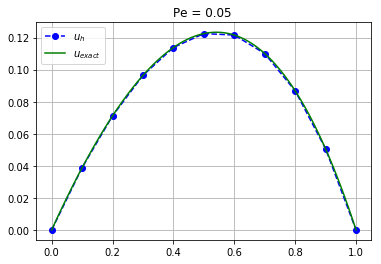

In [30]:
artificial_diffusion(1,1,10)

Pe = 0.5
Effective Pe =  0.46211715726000974


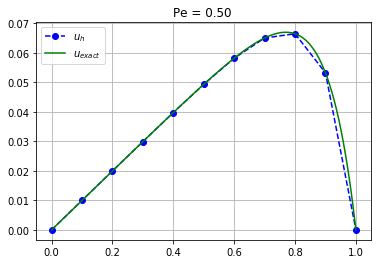

In [31]:
artificial_diffusion(1,10,10)

Pe = 1.0
Effective Pe =  0.761594155955765


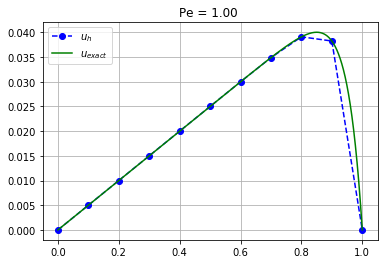

In [35]:
artificial_diffusion(1,20,10)

Pe = 2.5
Effective Pe =  0.9866142981514302


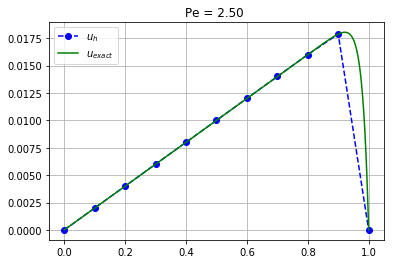

In [32]:
artificial_diffusion(1,50,10)

Pe = 5.0
Effective Pe =  0.9999092042625951


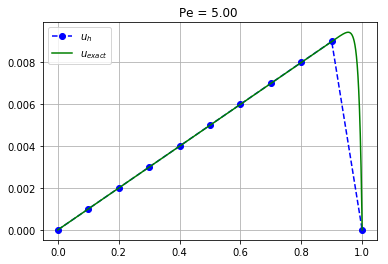

In [33]:
artificial_diffusion(1,100,10)

Pe = 25.0
Effective Pe =  1.0


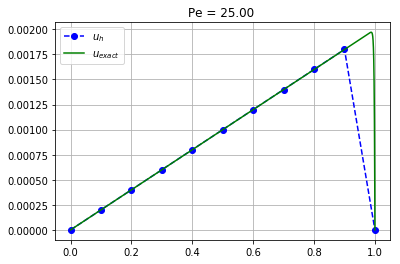

In [34]:
artificial_diffusion(1,500,10)

# SUPG

In this method, the modified test function $ v + \delta b v' $ is used. Where $\delta$ is a mesh dependent stabilization parameter.

Multiplying by test function $ v+\delta b v' $ on both sides of the convection-diffusion equation and integrating by parts over the domain $\Omega$

$$ \int_\Omega (-\epsilon u''+bu')(v + \delta b v') dx = \int_\Omega (v + \delta b v') dx $$

$$ \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx = \int_\Omega (v + \delta b v') dx $$  

Variational formulation:

$$ u \in V: \;\;\;\;\;a(u,v) = l(v) \;\;\;\;\forall v \in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx $$

$$ l(v) := \int_\Omega (v + \delta b v') dx $$

$\delta$ is a mesh dependent stabilization parameter. Choose $\delta = \frac{h}{2b}\left(\textrm{coth}Pe - \frac{1}{Pe}\right)$

Let us write a function `supg` to solve the problem.

In [36]:
def supg(epsilon, b, N):
    """Solves the 1-d problem by SUPG
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon
    
    mesh = fe.UnitIntervalMesh(N)
    
    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)
    
    delta = (h/(2*b))*( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    
    V = fe.FunctionSpace(mesh, 'CG', 1)
    
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    
    x = fe.SpatialCoordinate(mesh)[0]
    
    f = fe.Constant(1)
    
    boundary_ids = {1,2} # boundaries x=0 and x=1
    bc = fe.DirichletBC(V,0,boundary_ids) # Boundary conditions for x=0and x=1, u=0
    
    uh = fe.Function(V)
    
    L = f*v*fe.dx + delta*b*v.dx(0)*fe.dx
    a = ( e * fe.dot(fe.grad(v),fe.grad(u)) ) * fe.dx + ( b * u.dx(0) * v * fe.dx) + delta * b * b * fe.dot(fe.grad(v),fe.grad(u)) * fe.dx
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return 

Pe = 0.05


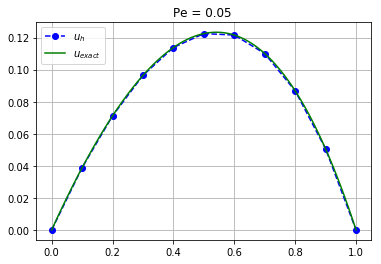

In [37]:
supg(1,1,10)

Pe = 0.5


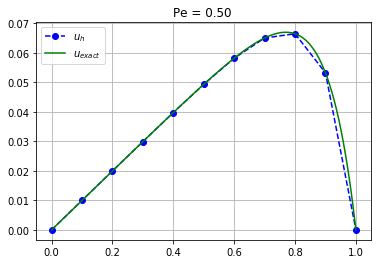

In [38]:
supg(1,10,10)

Pe = 1.0


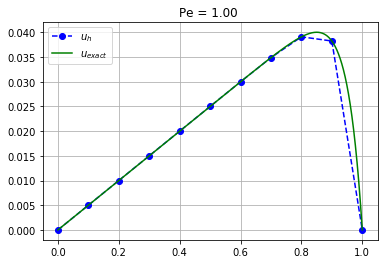

In [39]:
supg(1,20,10)

Pe = 2.5


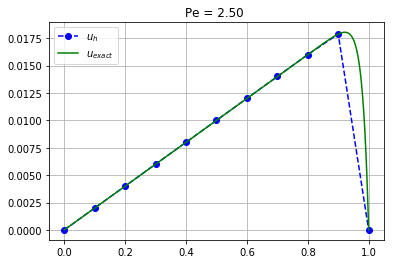

In [40]:
supg(1,50,10)

Pe = 10.0


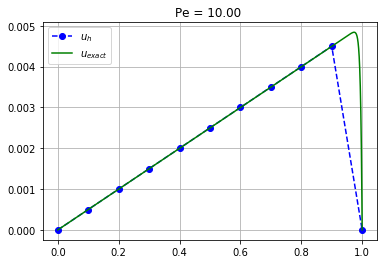

In [41]:
supg(1,200,10)

Pe = 25.0


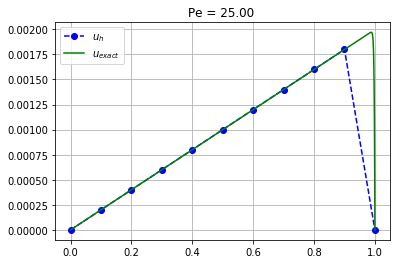

In [42]:
supg(1,500,10)

# 2d problem

Consider the 2d convection-diffusion equation with dirichlet boundary condition :

$$ -\epsilon \nabla^2u + b.\nabla u = 0,\;\;\textrm{in} \;\;\Omega = [0,1]\times[0,1]$$

$$ u = 1\;\;\;\forall x=0$$

$$ u = 0\;\;\;\forall y=0 $$



where, $\epsilon$ and b are diffusion and convection coefficients respectively.
We seek to find the solution $u \in V$, where $V$ is some finite element space satisfying the boundary condition.

# Galerkin

We write the above problem in variational form by multiplying by test function $v \in V$ and integrating by parts over domain $\Omega$ 

$$ \epsilon \iint_\Omega (\nabla u. \nabla v) \,dx\,dy + \iint_\Omega (b. \nabla u) \;v\,dx\,dy = 0$$

Now let us write the problem in compact form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := \epsilon \iint_\Omega (\nabla u. \nabla v) \,dx\,dy + \iint_\Omega (b. \nabla u) \;v\,dx\,dy$$

$$ l(v) := 0 $$

Let us write a function `galerkin2d` to solve the above problem by galerkin. Let the convection coeffient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [40]:
def galerkin2d(epsilon,N):
    """Solves the 2-d problem by Galerin
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon

    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 

    uh = fe.Function(V)
    L = f* v *fe.dx
    a =  e * fe.dot( fe.grad(v), fe.grad(u))  * fe.dx + fe.dot(b, fe.grad(u)) * v * fe.dx

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    
    fe.plot(uh, plot3d = 'TRUE')
    
    return
    


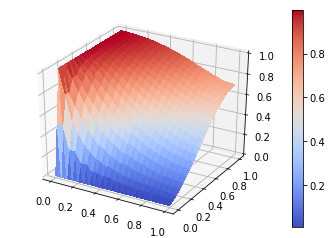

In [10]:
galerkin2d(0.1,10)

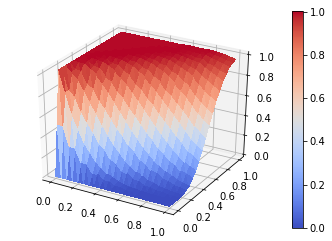

In [11]:
galerkin2d(0.01,10)

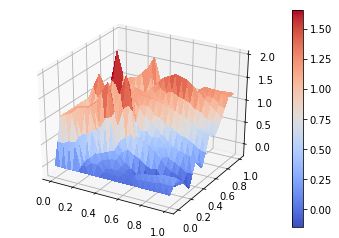

In [12]:
galerkin2d(0.001,10)

# Artficial diffusion

In this method, an artificial diffusion is added such that it reduces the mesh Peclet number to an effective Peclet number of almost unity.

Now, the variational form becomes
$$ (\epsilon+\epsilon_h) \iint_\Omega (\nabla u. \nabla v) dx\,dy + \iint_\Omega (b.\nabla u) \;v\,dx\,dy =  0 $$
where, $\epsilon_h$ is the artificial diffusion coefficient.

Now let us write the problem in bilinear form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := (\epsilon+\epsilon_h) \iint_\Omega (\nabla u. \nabla v) dx\,dy + \iint_\Omega (b.\nabla u) \;v\,dx\,dy$$

$$ l(v) :=  0 $$

The value of $\epsilon_h$ is chosen such that it reduces the Peclet number. Choose $ \epsilon_h = \frac{\gamma}{2} hb$. 

If $\gamma \geq 1$, the effective Peclet number is sufficiently small and hence diffusion is minimized.

For perfect stabilization use $\gamma = \textrm{coth}(Pe)-1/Pe$

Let us write a function `artificial_diffusion2d` to solve the above 2d problem by artificial diffusion. Let the convection coeffient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [42]:
def artificial_diffusion2d(epsilon,N):
    """Solves the 2-d problem by Artificial diffusion
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon
    h = 1/N
    
    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 

    pe = fe.sqrt(fe.dot(b,b))*h/(2*fe.sqrt(fe.dot(e,e))) # Peclet Number
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    eh = gamma/2*h*fe.sqrt(fe.dot(b,b)) # artificial diffusion coefficient

    uh = fe.Function(V)
    L = f * v * fe.dx
    a =   (e+eh) * fe.dot( fe.grad(u), fe.grad(v))  * fe.dx  + fe.dot(b, fe.grad(u)) * v * fe.dx 

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    
    fe.plot(uh, plot3d = 'TRUE')
    
    return

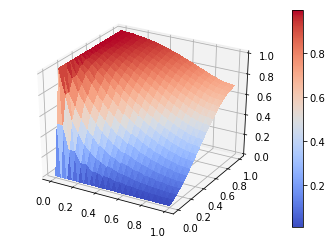

In [27]:
artificial_diffusion2d(0.1,10)

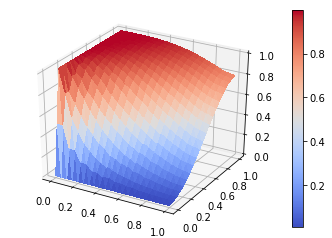

In [28]:
artificial_diffusion2d(0.01,10)

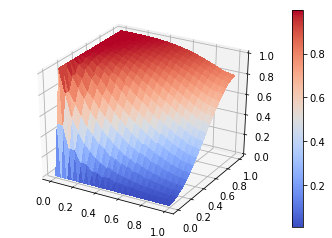

In [29]:
artificial_diffusion2d(0.001,10)

# SUPG

In this method, the modified test function $ v + \delta b \nabla v $ is used. Where $\delta$ is a mesh dependent stabilization parameter.

Multiplying by test function $ v+\delta b \nabla v $ on both sides of the convection-diffusion equation and integrating by parts over domain $\Omega$

$$ \iint_\Omega (-\epsilon \nabla^2u + b.\nabla u)(v+\delta\, b. \nabla v) dx\,dy = 0 $$

$$ \epsilon \iint_\Omega (\nabla u.\nabla v)\, dx\,dy + \iint_\Omega (b.\nabla u) \,v\,dx\,dy + \delta \iint_\Omega (b.\nabla u) (b.\nabla v)\, dx\,dy = 0 $$  

Variational formulation:

$$ u \in V: \;\;\;\;\;a(u,v) = l(v) \;\;\;\;\forall v \in V$$

$$ a(u,v) := \epsilon \iint_\Omega (\nabla u.\nabla v)\, dx\,dy + \iint_\Omega (b.\nabla u) \,v\,dx\,dy + \delta \iint_\Omega (b.\nabla u) (b.\nabla v)\, dx\,dy $$

$$ l(v) := 0 $$

$\delta$ is a mesh dependent stabilization parameter. Choose $\delta = \frac{h}{2b}\left(\textrm{coth}Pe - \frac{1}{Pe}\right)$

Let us write a function `supg2d` to solve the above 2d problem by SUPG. Let the convection coefficient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [39]:
def supg2d(epsilon,N):
    """Solves the 2-d problem by SUPG
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon
    h = 1/N
    
    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 
    
    pe = fe.sqrt(fe.dot(b,b))*h/2/e # Peclet Number
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    delta = h/(2*fe.sqrt(fe.dot(b,b)))*( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)

    uh = fe.Function(V)
    L = f*v*fe.dx + delta*fe.dot(b,fe.grad(v))*f*fe.dx
    a =  e * fe.dot( fe.grad(v), fe.grad(u)) * fe.dx + fe.dot(b,fe.grad(u)) * v * fe.dx + delta * fe.dot(b,fe.grad(u))*fe.dot(b,fe.grad(v)) * fe.dx

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    
    fe.plot(uh, plot3d = 'TRUE')
    
    return

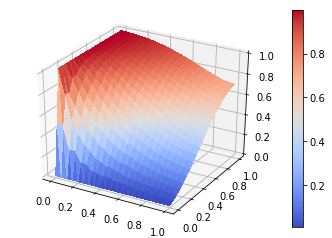

In [36]:
supg2d(0.1,10)

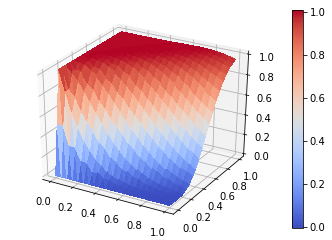

In [37]:
supg2d(0.01,10)

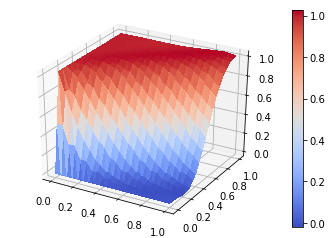

In [38]:
supg2d(0.001,10)

# Conclusion

It can be seen that Galerkin method is not suited for convection dominated problems i.e $Pe >1$. Artificial diffusion method produces stable solution but lacks consistency. SUPG is a strongly consistent method of solving convection-diffusion equations.